# E2E_santander
This notebook is for **Archive Only.** Please **do not** expect it to run in the latest releases.  Cell output is saved and shown.  

Placed 17/8808. [Blog](https://medium.com/rapids-ai/financial-data-modeling-with-rapids-5bca466f348) 

In [1]:
import cudf as gd
import pandas as pd
import time
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

This notebook includes the best single model of Rapids.ai team for [Santander Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction/leaderboard). We placed **17/8808** in the competition.

### Reading CSV

In [2]:
%%time

PATH = '../input'
cols = ['ID_code', 'target'] + ['var_%d'%i for i in range(200)]
dtypes = ['int32', 'int32'] + ['float32' for i in range(200)]
train_gd = gd.read_csv('%s/train.csv'%PATH,names=cols,dtype=dtypes,skiprows=1)
print(train_gd.shape)

(200000, 202)
CPU times: user 300 ms, sys: 292 ms, total: 592 ms
Wall time: 593 ms


### KDE for a single column

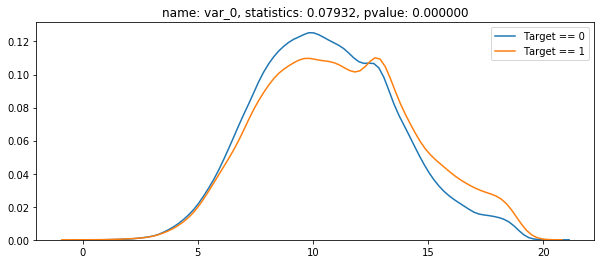

In [3]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = train_gd.to_pandas()
target_mask = train['target'] == 1
non_target_mask = train['target'] == 0 
statistics_array = []
for col in train.columns[2:]:
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    statistics_array.append(statistic)
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.kdeplot(train.loc[non_target_mask, col], ax=ax, label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=ax, label='Target == 1')

    ax.set_title('name: {}, statistics: {:.5f}, pvalue: {:5f}'.format(col, statistic, pvalue))
    break

### Count encoding

In [4]:
%%time
for i in range(200):
    col = 'var_%d'%i
    var_count = train_gd.groupby(col).agg({col:'count'})
    var_count.columns = ['%s_count'%col]
    var_count = var_count.reset_index()
    train_gd = train_gd.merge(var_count,on=col,how='left')

CPU times: user 32.6 s, sys: 1min 51s, total: 2min 24s
Wall time: 2min 30s


### Visualizing patterns of count==1 group

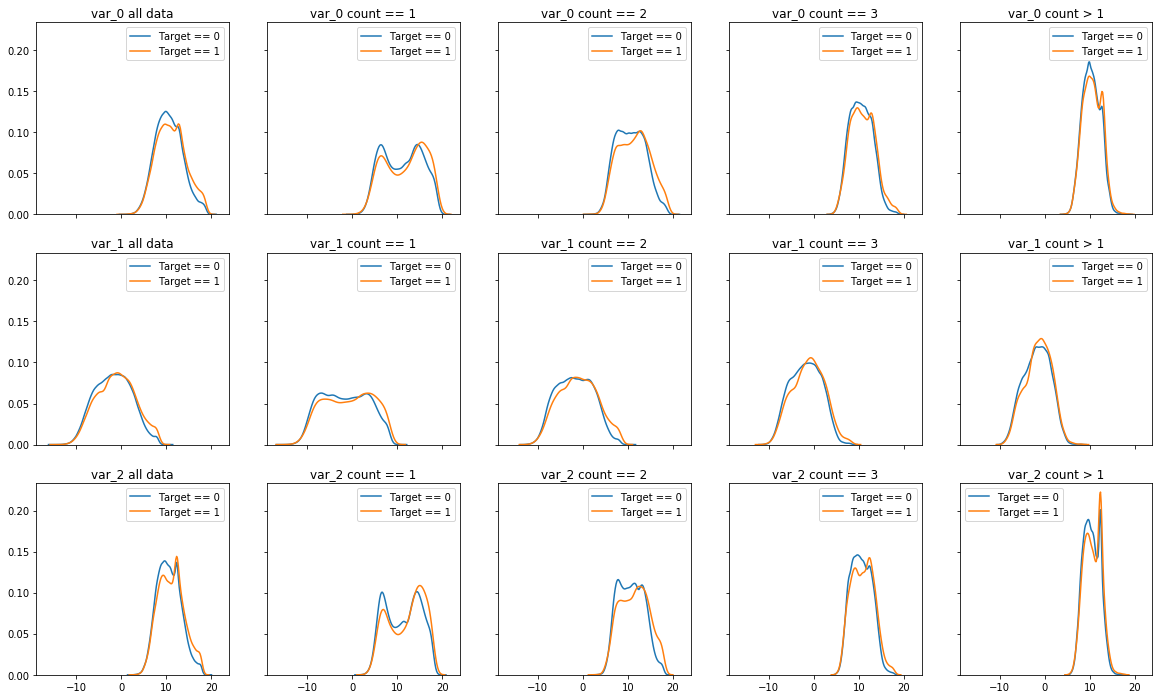

In [5]:
train = train_gd.to_pandas()
fig, axs = plt.subplots(3,5, figsize=(20, 12),sharex=True,sharey=True)
target_mask = train['target'] == 1
non_target_mask = train['target'] == 0 

for c,col in enumerate(['var_0','var_1','var_2']):
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    sns.kdeplot(train.loc[non_target_mask, col], ax=axs[c,0], label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=axs[c,0], label='Target == 1')
    axs[c,0].set_title('%s all data'%col)

for c,col in enumerate(['var_0','var_1','var_2']):
    for i in range(1,4):
        train = train_gd.to_pandas()
        train = train[train['%s_count'%col]==i]
        target_mask = train['target'] == 1
        non_target_mask = train['target'] == 0 
        statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
        sns.kdeplot(train.loc[non_target_mask, col], ax=axs[c,i], label='Target == 0')
        sns.kdeplot(train.loc[target_mask, col], ax=axs[c,i], label='Target == 1')
        axs[c,i].set_title('%s count == %d'%(col,i))

for c,col in enumerate(['var_0','var_1','var_2']):
    train = train_gd.to_pandas()
    train = train[train['%s_count'%col]>i]
    target_mask = train['target'] == 1
    non_target_mask = train['target'] == 0 
    statistic, pvalue = ks_2samp(train.loc[non_target_mask, col], train.loc[target_mask, col])
    sns.kdeplot(train.loc[non_target_mask, col], ax=axs[c,4], label='Target == 0')
    sns.kdeplot(train.loc[target_mask, col], ax=axs[c,4], label='Target == 1')
    axs[c,4].set_title('%s count > 1'%(col))

### Add new features by removing count==1 group

In [6]:
%%time
for i in range(200):
    col = 'var_%d'%i
    dg = train_gd[[col,'%s_count'%col,'ID_code']].query("%s_count > 1"%col)
    dg.columns = ['%s_gt1'%col,'%s_count'%col,'ID_code']
    train_gd = train_gd.merge(dg[['ID_code','%s_gt1'%col]],on='ID_code',how='left')

CPU times: user 1min 18s, sys: 3min 6s, total: 4min 25s
Wall time: 4min 35s


### Train and validation split

In [7]:
train,valid = train_gd[:-10000],train_gd[-10000:]

In [8]:
x_train = train.drop(['target','ID_code'])
y_train = train['target']
x_valid = valid.drop(['target','ID_code'])
y_valid = valid['target']

### XGB training

In [9]:
%%time
xgb_params = {
            'objective': 'binary:logistic',
            'tree_method': 'gpu_hist',
            'max_depth': 1, 
            'eta':0.1,
            'silent':1,
            'subsample':0.5,
            'colsample_bytree': 0.05,  
            'eval_metric':'auc',
}
dtrain = xgb.DMatrix(data=x_train.to_pandas(), label=y_train.to_pandas())
dvalid = xgb.DMatrix(data=x_valid.to_pandas(), label=y_valid.to_pandas())

CPU times: user 1min 23s, sys: 13.1 s, total: 1min 36s
Wall time: 7.11 s


In [10]:
%%time

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(xgb_params, dtrain=dtrain,
                num_boost_round=10000,evals=watchlist,
                early_stopping_rounds=30,maximize=True,
                verbose_eval=1000)
yp = clf.predict(dvalid)

[0]	eval-auc:0.521389	train-auc:0.52936
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 30 rounds.
[1000]	eval-auc:0.895451	train-auc:0.897593
[2000]	eval-auc:0.912287	train-auc:0.914978
[3000]	eval-auc:0.918509	train-auc:0.921984
[4000]	eval-auc:0.921146	train-auc:0.925312
[5000]	eval-auc:0.922234	train-auc:0.927468
[6000]	eval-auc:0.923024	train-auc:0.929098
[7000]	eval-auc:0.922959	train-auc:0.930512
[8000]	eval-auc:0.922511	train-auc:0.931767
[9000]	eval-auc:0.922827	train-auc:0.932826
[9999]	eval-auc:0.922667	train-auc:0.933797
CPU times: user 2h 32min 30s, sys: 8min 21s, total: 2h 40min 51s
Wall time: 2min 4s


plot top10 important features


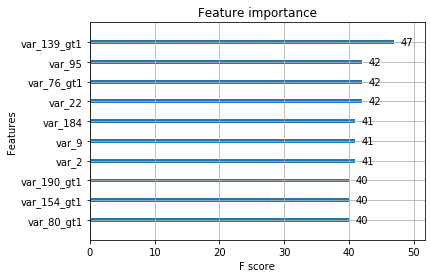

In [11]:
import matplotlib.pyplot as plt
print('plot top10 important features')
xgb.plot_importance(clf,max_num_features=10)
plt.show()